In [75]:
# 相關套件載入
import pandas as pd
import numpy as np
import random as rn
import pydotplus # 繪製tensflow圖
import graphviz # 繪製tensflow圖


from tensorflow.keras.layers import Embedding, Dropout, Input, Dense, Reshape, Concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model

In [76]:
cate_embedding_dimension = {'0':3, '1':2}
 
def build_embedding_network():
 
    '''
    通常寫法會將dataframe資料調整，將類別變數放置dataframe前面位置
    ''' 
    
    inputs = []
    embeddings = []
    
    ### 所有dataframe的特徵都需寫進行E.E中，一個資料集如有3個欄位(2個類別特徵，1個數值特徵)
    ### 就必須寫3次。通常為了後續容易了解，我們先將類別的向量嵌入寫在前面，
    ### 而且需增加Embedding嵌入資料，再用Reshape拉直。
    ### 數值資料只需增加Dense
    
    input_cate_feature_1 = Input(shape=(1,))
    embedding = Embedding(10, 3, input_length=1, name = 'EE_C1')(input_cate_feature_1) # name可以命名該層名稱
    # embedding後是10*1*3，為了後續计算方便，因此使用Reshape轉為10*3(易使後續concat)
    embedding = Reshape(target_shape=(3,))(embedding)
    inputs.append(input_cate_feature_1)
    embeddings.append(embedding)
    
    input_cate_feature_2 = Input(shape=(1,))
    embedding = Embedding(4, 2, input_length=1, name = 'EE_C2')(input_cate_feature_2)
    embedding = Reshape(target_shape=(2,))(embedding)
    inputs.append(input_cate_feature_2)
    embeddings.append(embedding)
    
    input_numeric = Input(shape=(1,))
    embedding_numeric = Dense(1)(input_numeric) 
    inputs.append(input_numeric)
    embeddings.append(embedding_numeric)
 
    # 此一過程，再於將所有嵌入後的類別資料以及數值資料(不需調整)，拉成一條
    x = Concatenate()(embeddings)
    
    # 經過二層Dense
    x = Dense(10, activation='relu')(x)
    #x = Dropout(.15)(x)
    x = Dense(10, activation='relu')(x)
    #x = Dropout(.15)(x)
    
    # 最後進行output輸出
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, output)
 
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
    
    return model

In [77]:
# 建置資料以進行實作

sample_num = 32 # 觀察值為32
cate_feature_num = 2 # 類別特徵 2
contious_feature_num = 1 # 數值特徵 1
 
rng = np.random.RandomState(123)
cate_feature_1 = rng.randint(10, size=(32, 1))
cate_feature_2 = rng.randint(4, size=(32, 1))
contious_feature = rng.rand(32,1)


## 需特別留意，如果資料集為dataframe需轉成以下格式 !!
X = []
X.append(cate_feature_1)
X.append(cate_feature_2)
X.append(contious_feature)

# 目標變數為二分類
Y = np.random.randint(2, size=(32, 1))

In [78]:
# 訓練模型：此一階段主要在於透過back-propagation，訓練嵌入的類別資料在所有特徵以及目標變數中的向量空間

NN = build_embedding_network()
NN.fit(X, Y, epochs=30, batch_size=4, verbose=0)

# predict
# y_preds = NN.predict(X)[:,0]
 
# 繪出tensflow模型，需要GraphViz以及pydotplus套件

# import graphviz
# import pydotplus

#from keras.utils import plot_model
#plot_model(NN, to_file='NN.png')

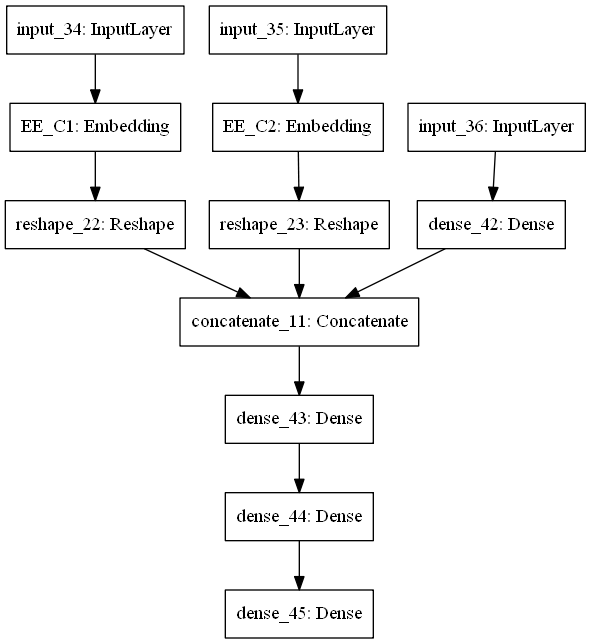

In [79]:
# 繪出tensflow模型，需要GraphViz以及pydotplus套件

# import graphviz
# import pydotplus

from tensorflow.keras.utils import plot_model
plot_model(NN, to_file='NN.png', show_layer_names=True)
# plot_model(NN, to_file='NN.png', show_shapes=True, show_layer_names=True) 完整寫法

In [32]:
model = NN  # 將訓練完成的模型存成物件
for i in range(cate_feature_num):
    # 由NN.png圖可知，如果把類別特徵放置在前、連續特徵放於後，cate_feature_num+i就是所有embedding層
    layer_name = NN.get_config()['layers'][cate_feature_num+i]['name']
 
    intermediate_layer_model = Model(inputs=NN.input,
                                     outputs=model.get_layer(layer_name).output)
    
    # numpy.array
    intermediate_output = intermediate_layer_model.predict(X)
    
    intermediate_output.resize([32,cate_embedding_dimension[str(i)]])
    
    if i == 0:
        X_embedding_trans = intermediate_output
    else:
        X_embedding_trans = np.hstack((X_embedding_trans,intermediate_output)) #水平拼接
    

# 取出原來的數值特徵
for i in range(contious_feature_num):
    if i == 0:
        X_contious = X[cate_feature_num+i]
    else:
        X_contious = np.hstack((X_contious,X[cate_feature_num+i]))

In [33]:
# 將所有資料堆疊起來
X_trans = np.hstack((X_embedding_trans,X_contious))

In [74]:
# 資料還原成dataframe格式
pd.DataFrame(X_trans)

,0,1,2,3,4,5
0,-0.018017,-0.048825,-0.034178,-0.007441,0.015471,0.501837
1,-0.018017,-0.048825,-0.034178,-0.007441,0.015471,0.623953
2,0.051063,0.037738,-0.044039,-0.007441,0.015471,0.115618
3,0.047009,-0.035040,-0.015834,0.027487,-0.014333,0.317285
4,-0.010112,-0.004788,-0.036145,0.002546,-0.027818,0.414826
5,0.050903,0.043063,-0.050133,0.002546,-0.027818,0.866309
6,0.051063,0.037738,-0.044039,0.027487,-0.014333,0.250455
7,0.047009,-0.035040,-0.015834,0.027487,-0.014333,0.483034
8,-0.010902,-0.023473,-0.034260,0.042027,0.017358,0.985560
9,0.047009,-0.035040,-0.015834,0.027487,-0.014333,0.519485


In [ ]:
########################################### 以下為補充 ###################################

In [ ]:
model = NN

In [ ]:
# 可以找出模型命名的名字
model.get_config()['layers'][2]['name'] # 第一個類別嵌入層位置為2(第三個位置0、1、2)

In [95]:
# 可以找出模型命名的名字
model.get_config()['layers'][2]['name'] # 第一個類別嵌入層位置為2(第三個位置0、1、2)

'EE_C1'

In [100]:
# 三層模型
NN.input

[<tf.Tensor 'input_34:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'input_35:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'input_36:0' shape=(None, 1) dtype=float32>]

In [107]:
# 根據模型名字找出對應輸出
model.get_layer('EE_C1').output

<tf.Tensor 'EE_C1_3/Identity:0' shape=(None, 1, 3) dtype=float32>

In [109]:
# 建立對應的嵌入向量
EE_C1O = Model(inputs=NN.input,outputs=model.get_layer('EE_C1').output)

In [111]:
# 根據原先的類別特徵，MAP出實體嵌入向量
EE_C1O.predict(X)

array([[[-0.23925039,  0.19716974,  0.1221888 ]],

       [[-0.23925039,  0.19716974,  0.1221888 ]],

       [[-0.13948058, -0.10934848, -0.07158469]],

       [[ 0.08909059,  0.0179732 ,  0.03896246]],

       [[-0.1334137 , -0.17575742, -0.23851459]],

       [[-0.17758176,  0.1634387 ,  0.08464627]],

       [[-0.13948058, -0.10934848, -0.07158469]],

       [[ 0.08909059,  0.0179732 ,  0.03896246]],

       [[ 0.07616051,  0.0278652 ,  0.06370997]],

       [[ 0.08909059,  0.0179732 ,  0.03896246]],

       [[-0.17758176,  0.1634387 ,  0.08464627]],

       [[ 0.07616051,  0.0278652 ,  0.06370997]],

       [[ 0.07616051,  0.0278652 ,  0.06370997]],

       [[-0.17758176,  0.1634387 ,  0.08464627]],

       [[-0.1334137 , -0.17575742, -0.23851459]],

       [[ 0.04948991,  0.01261899,  0.03042901]],

       [[ 0.07616051,  0.0278652 ,  0.06370997]],

       [[ 0.07616051,  0.0278652 ,  0.06370997]],

       [[ 0.04948991,  0.01261899,  0.03042901]],

       [[ 0.08909059,  0.017973